## PFDA Project - Contact Center Performance Analysis
by David O'Sullivan

## 1. Introduction

This notebook contains my analysis of PWCs contact centre data. The goal of the notebook is to analyse KPI's, spot trends and find ways to improve performance overall. The text in this notebook will be kept to a minimum as requested however some sections are more complex than others and require detailed explanations.

In [37]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading from MySQL

The code below is used to connect to a database I created in MySQL. As this is a public notebook I created a config file containing any sensitive information. I was unable to find a config file so created one within my terminal via bash scripts.

The next step was using mysql.connector.connect to establish a connection to the MySQL database. This was the most straightforawd step as we did this during the semester. As I only needed to run one straightforward query there was no need to create a cursor. Instead I defined the query and ran it with the connection to load it into the pandas dataframe (df = pd.read_sql(query, connection))

When originally running the code everything looked okay except for the time column. This was coming up as "0 days" followed by the time. I decided the best way to handle this was to use lambda to convert the column to a string and then slice it to only show the time section of the rows [7:15], excluding "0 Days". I'd be unable to analyse the data properly with time as a string so dt.time is used in the data preperation section to rectify this.

Refs:

Create INI config file : https://www.quora.com/How-do-you-create-an-INI-config-file

Connecting MySQL Using Connector : https://dev.mysql.com/doc/connector-python/en/connector-python-example-connecting.html

pd.read_sql : https://blog.panoply.io/how-to-read-a-sql-query-into-a-pandas-dataframe

lambda to change data type : https://stackoverflow.com/questions/51341532/want-to-use-a-lambda-function-to-change-the-type-of-a-cell-if-it-is-type-float



In [99]:
import mysql.connector
from configparser import ConfigParser

# Define the path to config file
config_path = '/Users/davidosullivan/Documents/my_project/config_files/config.ini'

# Read the config.ini file
config = ConfigParser()
config.read(config_path)

# Retrieve the database connection details
host = config.get('mysql', 'host')
user = config.get('mysql', 'user')
password = config.get('mysql', 'password')
database = config.get('mysql', 'database')

# Connect to the database
connection = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database
)

# Query to retrieve all data
query = "SELECT * FROM call_data"

# Load the data into a pandas DataFrame
df = pd.read_sql(query, connection)

# Close the connection to the database
connection.close()

# Convert the 'time' column to a string in the format HH:MM:SS (Removing the unneccessary sting data 0:7)
df['time'] = df['time'].apply(lambda x: str(x)[7:15])

df.head()


/var/folders/0d/mbrvmyx10n92tdtbjzgv0tjm0000gn/T/ipykernel_51527/3994963931.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


,call_id,agent,date,time,topic,answered,resolved,speed_of_answer_in_seconds,avg_talk_duration,satisfaction_rating
0,ID0001,Diane,2021-01-01,09:12:58,Contract related,Y,Y,109.0,0:02:23,3.0
1,ID0002,Becky,2021-01-01,09:12:58,Technical Support,Y,N,70.0,0:04:02,3.0
2,ID0003,Stewart,2021-01-01,09:47:31,Contract related,Y,Y,10.0,0:02:11,3.0
3,ID0004,Greg,2021-01-01,09:47:31,Contract related,Y,Y,53.0,0:00:37,2.0
4,ID0005,Becky,2021-01-01,10:00:29,Payment related,Y,Y,95.0,0:01:00,3.0


In [100]:
# Set Index
df.set_index('date', inplace=True)
df.head()

,call_id,agent,time,topic,answered,resolved,speed_of_answer_in_seconds,avg_talk_duration,satisfaction_rating
date,,,,,,,,,
2021-01-01,ID0001,Diane,09:12:58,Contract related,Y,Y,109.0,0:02:23,3.0
2021-01-01,ID0002,Becky,09:12:58,Technical Support,Y,N,70.0,0:04:02,3.0
2021-01-01,ID0003,Stewart,09:47:31,Contract related,Y,Y,10.0,0:02:11,3.0
2021-01-01,ID0004,Greg,09:47:31,Contract related,Y,Y,53.0,0:00:37,2.0
2021-01-01,ID0005,Becky,10:00:29,Payment related,Y,Y,95.0,0:01:00,3.0


## 2. Data Preperation

Additional column converting average talk duration from minutes to seconds is needed for future analysis.

Refs:

https://stackoverflow.com/questions/5522031/convert-timedelta-to-total-seconds

https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.total_seconds.html

In [102]:
# Ensure 'AvgTalkDuration' is in string format
df['avg_talk_duration'] = df['avg_talk_duration'].astype(str)

# Convert 'AvgTalkDuration' to seconds
df['avg_talk_duration_seconds'] = pd.to_timedelta(df['avg_talk_duration']).dt.total_seconds()


There are three columns with 946 null values each. When running df.head(50) there is a clear trend where the null values are coming from, when the call isn't answered. Neither dropna() or fillna() would be benificial for analysis so null values are kept as is.

In [103]:
# Check are there null values to deal with
df.isnull().sum()

call_id                         0
agent                           0
time                            0
topic                           0
answered                        0
resolved                        0
speed_of_answer_in_seconds      0
avg_talk_duration               0
satisfaction_rating             1
avg_talk_duration_seconds     946
dtype: int64

In [104]:
# Check for duplicates
duplicates = df.duplicated().sum()
duplicates

0

In [105]:
# Drop Irrelevant Columns
df = df.drop(columns=['call_id'])
df.head()

,agent,time,topic,answered,resolved,speed_of_answer_in_seconds,avg_talk_duration,satisfaction_rating,avg_talk_duration_seconds
date,,,,,,,,,
2021-01-01,Diane,09:12:58,Contract related,Y,Y,109.0,0:02:23,3.0,143.0
2021-01-01,Becky,09:12:58,Technical Support,Y,N,70.0,0:04:02,3.0,242.0
2021-01-01,Stewart,09:47:31,Contract related,Y,Y,10.0,0:02:11,3.0,131.0
2021-01-01,Greg,09:47:31,Contract related,Y,Y,53.0,0:00:37,2.0,37.0
2021-01-01,Becky,10:00:29,Payment related,Y,Y,95.0,0:01:00,3.0,60.0


An additional column putting time of day into categories is needed for future analysis. This is done by combining pandas datetime function with IF, ELIF and ELSE statements.

Refs:

https://stackoverflow.com/questions/32375471/pandas-convert-strings-to-time-without-date


https://stackoverflow.com/questions/32113707/how-would-i-put-an-if-statement-inside-a-function

In [106]:
# Ensure in datetime format
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time

# Define a function to categorize the time
def categorise_time(time):
    if time >= pd.to_datetime('09:00:00').time() and time < pd.to_datetime('12:00:00').time():
        return 'Morning'
    elif time >= pd.to_datetime('12:00:00').time() and time < pd.to_datetime('15:00:00').time():
        return 'Afternoon'
    elif time >= pd.to_datetime('15:00:00').time() and time < pd.to_datetime('18:00:00').time():
        return 'Evening'
    else:
        return 'Night'

# Apply the function to create a new column
df['time_of_day_category'] = df['time'].apply(categorise_time)

# Display the first row to ensure the categorization
df.head(1)


,agent,time,topic,answered,resolved,speed_of_answer_in_seconds,avg_talk_duration,satisfaction_rating,avg_talk_duration_seconds,time_of_day_category
date,,,,,,,,,,
2021-01-01,Diane,09:12:58,Contract related,Y,Y,109.0,0:02:23,3.0,143.0,Morning


In [74]:
df['avg_talk_duration_seconds'].describe()

count    4054.000000
mean      224.922792
std       111.381555
min        30.000000
25%       130.000000
50%       226.000000
75%       319.000000
max       420.000000
Name: avg_talk_duration_seconds, dtype: float64

## Section 2 - EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 2021-01-01 to 2021-03-31
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   agent                       5000 non-null   object 
 1   time                        5000 non-null   object 
 2   topic                       5000 non-null   object 
 3   answered (y/n)              5000 non-null   object 
 4   resolved                    5000 non-null   object 
 5   speed of answer in seconds  4054 non-null   float64
 6   avgtalkduration             5000 non-null   object 
 7   satisfaction rating         4054 non-null   float64
 8   avgtalkduration_seconds     4054 non-null   float64
 9   time_of_day_category        5000 non-null   object 
dtypes: float64(3), object(7)
memory usage: 429.7+ KB


In [ ]:
df.describe()

,speed of answer in seconds,satisfaction rating,avgtalkduration_seconds
count,4054.000000,4054.000000,4054.000000
mean,67.520720,3.403552,224.922792
std,33.592872,1.212220,111.381555
min,10.000000,1.000000,30.000000
25%,39.000000,3.000000,130.000000
50%,68.000000,3.000000,226.000000
75%,97.000000,4.000000,319.000000
max,125.000000,5.000000,420.000000


In [ ]:
# Compute the correlation matrix 
columns_to_correlate = ['speed of answer in seconds','avgtalkduration_seconds', 'satisfaction rating']
correlation_matrix = df[columns_to_correlate].corr()
correlation_matrix

,speed of answer in seconds,avgtalkduration_seconds,satisfaction rating
speed of answer in seconds,1.000000,-0.002898,0.000952
avgtalkduration_seconds,-0.002898,1.000000,0.000143
satisfaction rating,0.000952,0.000143,1.000000


In [75]:
df.head()

,agent,time,topic,answered,resolved,speed_of_answer_in_seconds,avg_talk_duration,satisfaction_rating,avg_talk_duration_seconds,time_of_day_category
date,,,,,,,,,,
2021-01-01,Diane,09:12:58,Contract related,Y,Y,109.0,0:02:23,3.0,143.0,Morning
2021-01-01,Becky,09:12:58,Technical Support,Y,N,70.0,0:04:02,3.0,242.0,Morning
2021-01-01,Stewart,09:47:31,Contract related,Y,Y,10.0,0:02:11,3.0,131.0,Morning
2021-01-01,Greg,09:47:31,Contract related,Y,Y,53.0,0:00:37,2.0,37.0,Morning
2021-01-01,Becky,10:00:29,Payment related,Y,Y,95.0,0:01:00,3.0,60.0,Morning


## Business Insights Section

This is the main section of my analysis and it is broken into three seperate parts;

1) Resolution Rate & Unanswered Calls: Unanswered calls automatically make an issue unresolved so they are paired together for part one. In this section I explore if there is a trend to calls not being answered. After finding that trend I dive deeper into the data by doing some root cause analysis (RCA). PWC at a minimum should be aiming to answer every call which will then also improve the resolution rate. The resolution rate isn't soley dependent on calls being answered so I perform some additional analysis focusing on Agents & Topics looking for areas to focus on improving.

2) Customer Satisfaction: In the next part of my analysis I take a look at the customer satisfaction rating. This rating is on a scale of 1-5. PWC aim for excellence when it comes to customer service so in this section I analyse the data to pinpoint ways they can get this score as close to 5/5 consistently.

3) Predictive Analysis: In the final section I use predictive analysis to showcase to PWC what things will likely look like if adjustments aren't made. I use ML libraries to predict future unanswered calls as well as satisfaction ratings.



## Business Insights Part 1 - Resolution Rate & Unanswered Calls 




## Resolution Rate & Unanswered Calls




#### References

https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.bar_label.html



#### Resolved Issues %

In [76]:
# Resolved Issues %


# Calculate total issues
total_issues = df['resolved'].count()

# Count resolved issues
resolved_issues = (df['resolved'] == 'Y').sum()

# Calculate the percentage
percentage_resolved = (resolved_issues / total_issues) * 100

(f"Percentage of resolved issues: {percentage_resolved:.0f}%")


'Percentage of resolved issues: 73%'

#### Visualise Resolved Vs Unresolved Issues

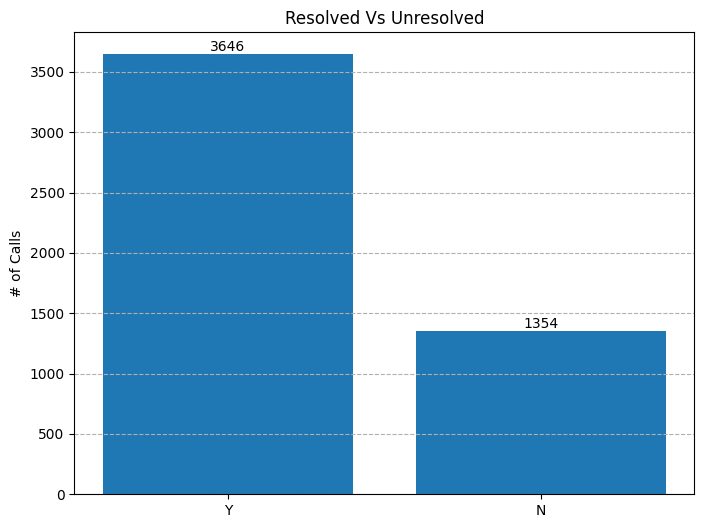

In [77]:
counts = df['resolved'].value_counts()

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(counts.index, counts.values)

# Add count labels to the bars
ax.bar_label(bars, fmt='%g', fontsize=10)

# Formatting the plot
ax.set_title('Resolved Vs Unresolved')
ax.set_xlabel('')
ax.set_ylabel('# of Calls')
ax.grid(axis='y', linestyle='--')

plt.show()

#### Resolution Rate by Topic, Agent & Time of Day

When looking at the resolution rates by topic and agent there isn't much that stands out, there isn't a major difference between the highest and lowest percentages.

In [78]:
# Calculate resolution rates by topic
resolution_by_topic = df.groupby('topic')['resolved'].apply(lambda x: (x == 'Y').mean() * 100).round(1)

# Calculate resolution rates by agent
resolution_by_agent = df.groupby('agent')['resolved'].apply(lambda x: (x == 'Y').mean() * 100).round(1)

# Display insights
print("Resolution Rate by Topic:\n", resolution_by_topic)
print("\nResolution Rate by Agent:\n", resolution_by_agent)


Resolution Rate by Topic:
 topic
Admin Support        74.1
Contract related     72.6
Payment related      72.4
Streaming            73.3
Technical Support    72.2
Name: resolved, dtype: float64

Resolution Rate by Agent:
 agent
Becky      73.2
Dan        74.4
Diane      71.4
Greg       72.9
Jim        72.8
Joe        73.5
Martha     72.3
Stewart    72.9
Name: resolved, dtype: float64


#### Unanswered Calls by Agent & Time of Day - Over 50% of unanswered calls are in the afternoon

In [80]:
# Unanswered call rate by agent
unanswered_by_agent = df[df['answered'] == 'N'].groupby('agent').size()

# Unanswered call rate by time of day
unanswered_by_time = df[df['answered'] == 'N'].groupby('time_of_day_category').size()

# Display insights
print("Unanswered Calls by Agent:\n", unanswered_by_agent)
print("\nUnanswered Calls by Time of Day:\n", unanswered_by_time)


Unanswered Calls by Agent:
 agent
Becky      114
Dan        110
Diane      132
Greg       122
Jim        130
Joe        109
Martha     124
Stewart    105
dtype: int64

Unanswered Calls by Time of Day:
 time_of_day_category
Afternoon    319
Evening      308
Morning      317
Night          2
dtype: int64


## Unanswered Calls - Root Cause Analysis

The below visual shows that the call volume in the afternoon is substantially greater than the volume of calls in the evening and morning time. 

Looking at this visual it indicates that the more calls that come in the more that aren't being answered. This is why below the visual I looked at the correlation between the volume of calls and unanswered calls. The correlation was 0.99 which shows that there is a strong positive relationship between the two.

I did this by creating the variable 'time_of_day_summary' which groups the time of day category and completes an aggregate function, in this case .sum(). Wiithin this variable I had to define total_calls with the count function and unanswered_calls using lambda. The lambda function creates a Boolean series, every 'N' value is True (or 1 numerically). The sum function the adds these together to provide the total number of unanswered calls.

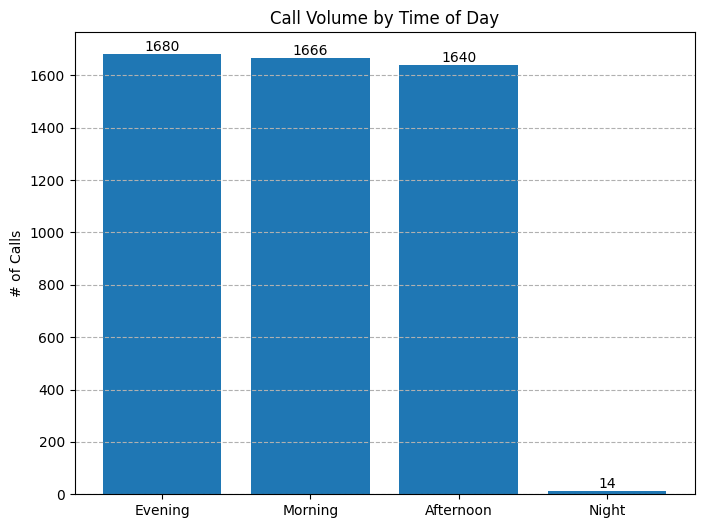

In [81]:
day_counts = df['time_of_day_category'].value_counts()

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(day_counts.index, day_counts.values)

# Add count labels to the bars
ax.bar_label(bars, fmt='%g', fontsize=10)

# Formatting the plot
ax.set_title('Call Volume by Time of Day')
ax.set_xlabel('')
ax.set_ylabel('# of Calls')
ax.grid(axis='y', linestyle='--')

plt.show()

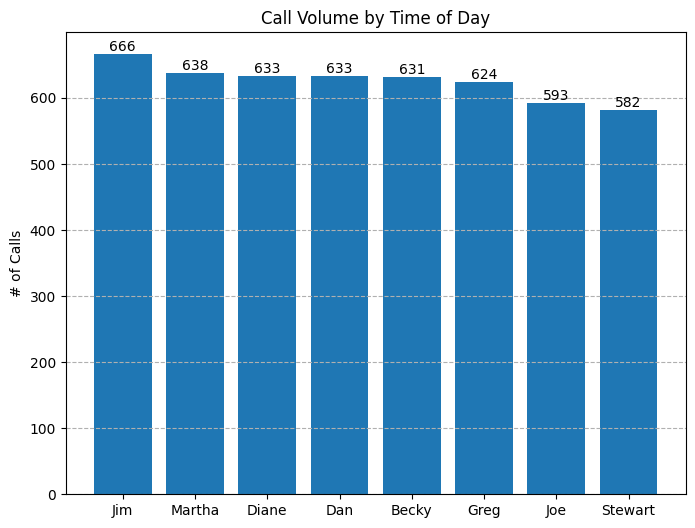

In [82]:
day_counts = df['agent'].value_counts()

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(day_counts.index, day_counts.values)

# Add count labels to the bars
ax.bar_label(bars, fmt='%g', fontsize=10)

# Formatting the plot
ax.set_title('Call Volume by Time of Day')
ax.set_xlabel('')
ax.set_ylabel('# of Calls')
ax.grid(axis='y', linestyle='--')

plt.show()

#### Correlation 

In [84]:
# Group data by time of day to calculate total and unanswered calls
time_of_day_summary = df.groupby('time_of_day_category').agg(total_calls=('answered', 'count'),unanswered_calls=('answered', lambda x: (x == 'N').sum()))

# Compute correlation
correlation_time_of_day = time_of_day_summary['total_calls'].corr(time_of_day_summary['unanswered_calls']).round(5)

print("Correlation between total calls and unanswered calls by time of day:", correlation_time_of_day)


Correlation between total calls and unanswered calls by time of day: 0.9988


The below analysis shows that there is close to no relationship between speed of answer and resolved issues as well as call duration and satisfaction rating.

#### Refs:
lambda w/ if statement : https://stackoverflow.com/questions/1585322/is-there-a-way-to-perform-if-in-pythons-lambda

In [88]:
# Correlation between speed of answer and resolution rate
df['resolved_numeric'] = df['resolved'].apply(lambda x: 1 if x == 'Y' else 0)
correlation_speed_resolution = df['speed_of_answer_in_seconds'].corr(df['resolved_numeric']).round(5)

# Correlation between satisfaction and talk duration
correlation_satisfaction_duration = df['avg_talk_duration_seconds'].corr(df['satisfaction_rating']).round(5)


print("Correlation between speed of answer and resolved issues:", correlation_speed_resolution)
print("Correlation between call duration and satisfaction rating:", correlation_satisfaction_duration)



Correlation between speed of answer and resolved issues: 0.52498
Correlation between call duration and satisfaction rating: 0.00014


## Predictive Analysis - What do the future numbers of unanswered calls look like?


#### References


#### Reminder 

- Check afternoon resolution rate
- Are there certain days where individual employees rack up most of their unanswered calls?

#### Resolution Rate Across all Times

In [91]:
# Average Speed of Answer for Answered Calls in the Afternoon
afternoon_answered = df[(df['time_of_day_category'] == 'Afternoon') & (df['answered'] == 'Y')]
afternoon_speed_of_answer = afternoon_answered['speed_of_answer_in_seconds'].mean()

## Business Insights Part 2 - Customer Satisfaction



#### References



#### Satisfaction by Resolution Status, Topic, Call Duration & Time of Day

** Key Callout here is that even when issues aren't resolved the average satisfaction score is still greater than the score where issues are resolved.

In [93]:
# Satisfaction by resolution status
satisfaction_by_resolution = df.groupby('resolved')['satisfaction_rating'].mean()

# Satisfaction by topic
satisfaction_by_topic = df.groupby('topic')['satisfaction_rating'].mean()

# Satisfaction by call duration
satisfaction_by_duration = df['avg_talk_duration_seconds'].corr(df['satisfaction_rating'])

# Satisfaction by Time of Day
satisfaction_by_time = df.groupby('time_of_day_category')['satisfaction_rating'].mean()

print("Satisfaction by Resolution:\n", satisfaction_by_resolution)
print("\nSatisfaction by Topic:\n", satisfaction_by_topic)
print(f"\nCorrelation between Call Duration and Satisfaction: {satisfaction_by_duration:.2f}")
print("Satisfaction By Time of Day:\n", satisfaction_by_time )


Satisfaction by Resolution:
 resolved
N    1.033999
Y    3.400713
Name: satisfaction_rating, dtype: float64

Satisfaction by Topic:
 topic
Admin Support        2.790984
Contract related     2.733333
Payment related      2.758689
Streaming            2.819961
Technical Support    2.697743
Name: satisfaction_rating, dtype: float64

Correlation between Call Duration and Satisfaction: 0.00
Satisfaction By Time of Day:
 time_of_day_category
Afternoon    2.695732
Evening      2.768314
Morning      2.812725
Night        3.071429
Name: satisfaction_rating, dtype: float64


#### Top & Bottom Performing Agents by Topics

When comparing the top performers to those at the bottom, the difference in average satisfaction rating is tiny and doesn't provide much insights.

In [96]:
# Agents by Topic Performers below Average
agent_topic_rating = df.groupby(['agent', 'topic'])['satisfaction_rating'].mean()
agent_topic_rating_df = agent_topic_rating.reset_index()
agent_topic_below_avg = agent_topic_rating_df[agent_topic_rating_df['satisfaction_rating'] < 3.4].sort_values('satisfaction_rating')

agent_topic_above_avg = agent_topic_rating_df[agent_topic_rating_df['satisfaction_rating'] > 3.4].sort_values('satisfaction_rating')

print('Above Average:\n', agent_topic_above_avg.tail())
print('Below Average:\n', agent_topic_below_avg.head())

Above Average:
 Empty DataFrame
Columns: [agent, topic, satisfaction_rating]
Index: []
Below Average:
      agent              topic  satisfaction_rating
1    Becky   Contract related             2.508772
34  Martha  Technical Support             2.550725
24     Jim  Technical Support             2.580882
27     Joe    Payment related             2.629032
11   Diane   Contract related             2.631148


#### References for Visuals

https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html

https://www.geeksforgeeks.org/python-pandas-dataframe-resample/

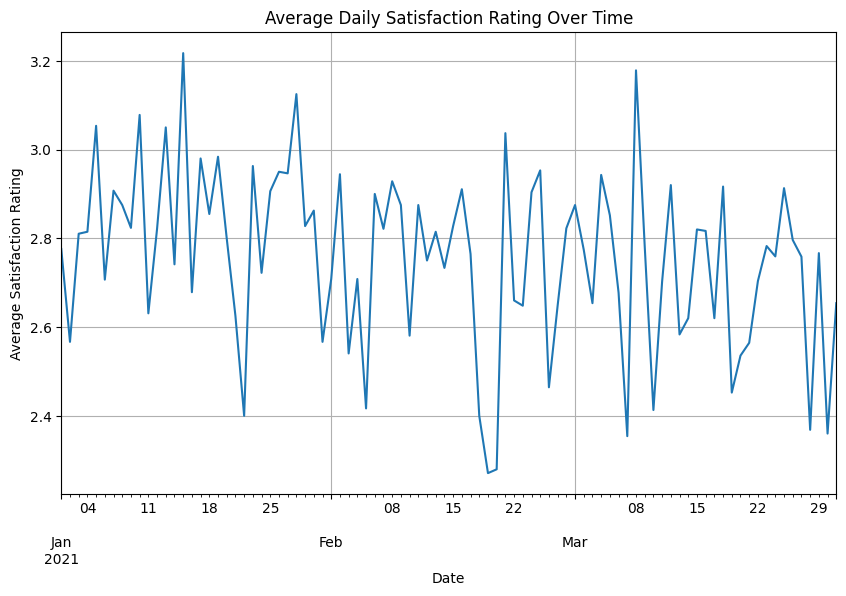

In [98]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure the index is of datetime type
df.index = pd.to_datetime(df.index)

# Resample the data to calculate the daily mean 
daily_average = df['satisfaction_rating'].resample('D').mean()

# Plotting and title
daily_average.plot(kind='line', figsize=(10, 6), title="Average Daily Satisfaction Rating Over Time")

# Adding labels
plt.xlabel("Date")
plt.ylabel("Average Satisfaction Rating")
plt.grid(True)

# Display the plot
plt.show()


In [ ]:
df.to_excel('/Users/davidosullivan/Desktop/ATU_DataAnalytics_Semester2/test.xlsx')